In [3]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import evaluate
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
root = "../dataset"

cnn = load_dataset(
    "parquet",
    data_files={
        "train":      f"{root}/cnn/train/*.parquet",
        "validation": f"{root}/cnn/validation/*.parquet",
        "test":       f"{root}/cnn/test/*.parquet", 
    }
)
test_dataset  = cnn["test"].select(range(1500))
len(test_dataset), test_dataset.column_names

(1500, ['article', 'highlights', 'id'])

In [5]:
rouge = evaluate.load("rouge")

def generate_summaries(model, tokenizer, texts, 
                       device="cuda" if torch.cuda.is_available() else "cpu",
                       batch_size=8,
                       max_input_length=1024,
                       max_new_tokens=128):
    model.to(device)
    model.eval()
    
    all_summaries = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenisasi
        inputs = tokenizer(
            batch_texts,
            max_length=max_input_length,
            truncation=True,
            padding=True,
            return_tensors="pt"
        ).to(device)
        
        with torch.no_grad():
            summary_ids = model.generate(
                **inputs,
                max_new_tokens=max_new_tokens,
                num_beams=4,
                length_penalty=2.0,
                early_stopping=True,
            )
        
        batch_summaries = tokenizer.batch_decode(
            summary_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
        )
        all_summaries.extend(batch_summaries)
    
    return all_summaries


def compute_rouge(preds, refs):
    # ROUGE evaluate expects list of strings
    result = rouge.compute(
        predictions=[p.strip() for p in preds],
        references=[r.strip() for r in refs],
        use_stemmer=True
    )
    # Ambil hanya rouge1, rouge2, rougeL, rougeLsum
    return {
        "rouge1": result["rouge1"],
        "rouge2": result["rouge2"],
        "rougeL": result["rougeL"],
        "rougeLsum": result["rougeLsum"],
    }


In [6]:
articles = test_dataset["article"]
references = test_dataset["highlights"]

len(articles), len(references)


(1500, 1500)

In [7]:
base_model_name = "facebook/bart-base"
custom_model_name = "brotoo/BART-NewsSummarizer"  # ganti kalau nama lain

tokenizer_base = AutoTokenizer.from_pretrained(base_model_name)
model_base = AutoModelForSeq2SeqLM.from_pretrained(base_model_name)

tokenizer_custom = AutoTokenizer.from_pretrained(custom_model_name)
model_custom = AutoModelForSeq2SeqLM.from_pretrained(custom_model_name)


In [8]:
preds_base = generate_summaries(
    model=model_base,
    tokenizer=tokenizer_base,
    texts=articles,
    batch_size=8,          # bisa disesuaikan dengan VRAM
    max_input_length=1024,
    max_new_tokens=128,
)

rouge_base = compute_rouge(preds_base, references)
rouge_base

{'rouge1': np.float64(0.30517703610845537),
 'rouge2': np.float64(0.12792950171521927),
 'rougeL': np.float64(0.1998416159363915),
 'rougeLsum': np.float64(0.24583705087885724)}

In [11]:
# Hardcode hasil ROUGE dari model custom kamu
rouge_custom = {
    "rouge1": 0.35981904833861045,
    "rouge2": 0.15595646040273925,
    "rougeL": 0.2621508398425323,
    "rougeLsum": 0.3320407701281053
}

rouge_custom

{'rouge1': 0.35981904833861045,
 'rouge2': 0.15595646040273925,
 'rougeL': 0.2621508398425323,
 'rougeLsum': 0.3320407701281053}

In [12]:
metrics = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

data = {
    "metric": metrics,
    "bart-base": [rouge_base[m] for m in metrics],
    "BART-NewsSummarizer": [rouge_custom[m] for m in metrics],
}

df_results = pd.DataFrame(data)
df_results


,metric,bart-base,BART-NewsSummarizer
0,rouge1,0.305177,0.359819
1,rouge2,0.127930,0.155956
2,rougeL,0.199842,0.262151
3,rougeLsum,0.245837,0.332041


In [13]:
df_results_pct = df_results.copy()
df_results_pct["bart-base"] = df_results_pct["bart-base"] * 100
df_results_pct["BART-NewsSummarizer"] = df_results_pct["BART-NewsSummarizer"] * 100
df_results_pct


,metric,bart-base,BART-NewsSummarizer
0,rouge1,30.517704,35.981905
1,rouge2,12.792950,15.595646
2,rougeL,19.984162,26.215084
3,rougeLsum,24.583705,33.204077


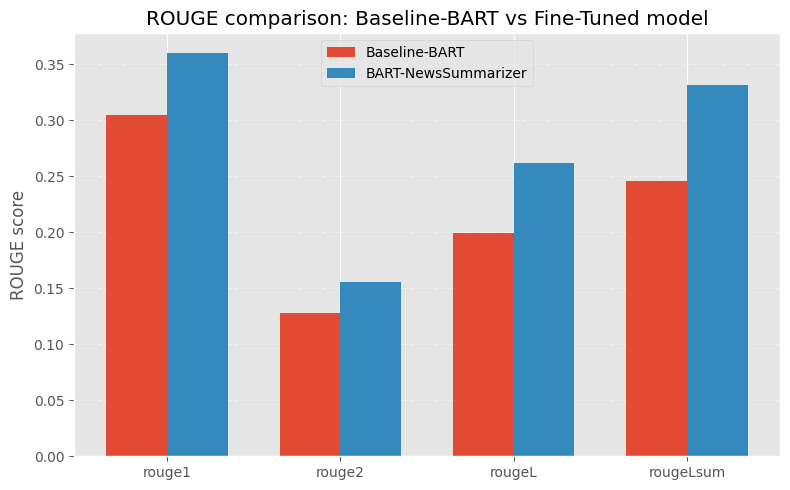

In [18]:
plt.figure(figsize=(8, 5))

x = range(len(metrics))
width = 0.35

plt.style.use("ggplot")
plt.bar(
    [i - width/2 for i in x],
    df_results["bart-base"],
    width=width,
    label="Baseline-BART",
)
plt.bar(
    [i + width/2 for i in x],
    df_results["BART-NewsSummarizer"],
    width=width,
    label="BART-NewsSummarizer",
)

plt.xticks(x, metrics)
plt.ylabel("ROUGE score")
plt.title("ROUGE comparison: Baseline-BART vs Fine-Tuned model")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

In [19]:
data = {
    "epoch": [1, 2, 3, 4, 5, 6],
    "train_loss": [2.019500, 1.833800, 1.704400, 1.628200, 1.544900, 1.488600],
    "val_loss":   [1.878123, 1.848299, 1.852839, 1.843191, 1.853586, 1.860694],
    "rouge1":     [35.825700, 35.567600, 36.445200, 37.105300, 36.805700, 36.594800],
    "rouge2":     [15.596600, 15.469000, 15.984100, 16.154000, 15.840800, 15.673700],
    "rougel":     [25.900000, 25.761100, 26.184200, 26.377900, 26.194500, 26.026100],
    "rougelsum":  [32.983900, 32.904600, 33.707400, 34.262400, 33.984200, 33.781600],
}

df = pd.DataFrame(data)
df

,epoch,train_loss,val_loss,rouge1,rouge2,rougel,rougelsum
0,1,2.0195,1.878123,35.8257,15.5966,25.9000,32.9839
1,2,1.8338,1.848299,35.5676,15.4690,25.7611,32.9046
2,3,1.7044,1.852839,36.4452,15.9841,26.1842,33.7074
3,4,1.6282,1.843191,37.1053,16.1540,26.3779,34.2624
4,5,1.5449,1.853586,36.8057,15.8408,26.1945,33.9842
5,6,1.4886,1.860694,36.5948,15.6737,26.0261,33.7816


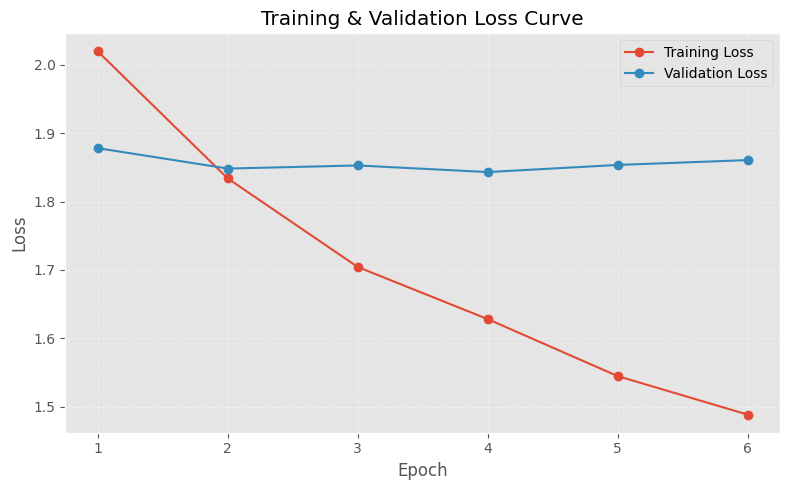

In [20]:
plt.figure(figsize=(8,5))

plt.plot(df["epoch"], df["train_loss"], marker="o", label="Training Loss")
plt.plot(df["epoch"], df["val_loss"], marker="o", label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()

plt.tight_layout()
plt.show()


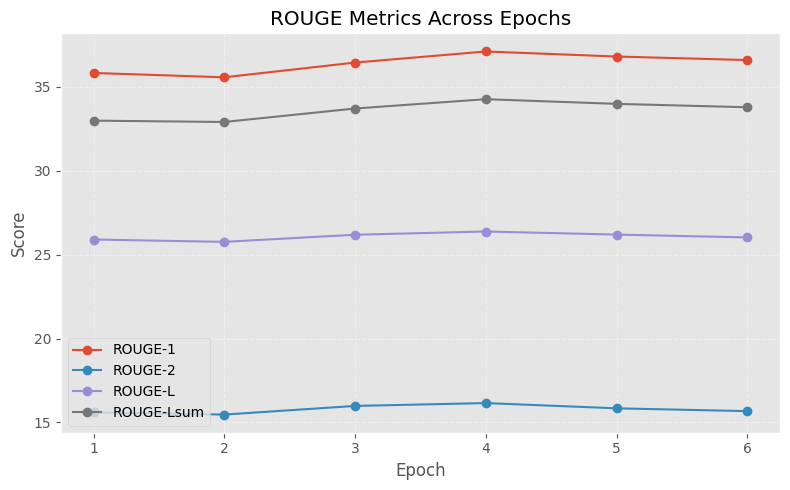

In [21]:
plt.figure(figsize=(8,5))

plt.plot(df["epoch"], df["rouge1"], marker="o", label="ROUGE-1")
plt.plot(df["epoch"], df["rouge2"], marker="o", label="ROUGE-2")
plt.plot(df["epoch"], df["rougel"], marker="o", label="ROUGE-L")
plt.plot(df["epoch"], df["rougelsum"], marker="o", label="ROUGE-Lsum")

plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("ROUGE Metrics Across Epochs")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()

plt.tight_layout()
plt.show()
